In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def find_data_dir():
    data_path = 'data'
    while os.path.exists(data_path) != True:
        data_path = '../' + data_path
        
    return data_path

In [2]:
# MNIST dataset

transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root=find_data_dir(),
                          train=True,
                          transform=transform,
                          download=True)
print("Downloading Train Data Done ! ")

mnist_test = datasets.MNIST(root=find_data_dir(),
                         train=False,
                         transform=transform,
                         download=True)
print("Downloading Test Data Done ! ")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# our model
class Generator(nn.Module):
    def __init__(self, n_z=100, n_c=10, d=128):
        super(Generator, self).__init__()
        
        self.deconv1_z = nn.ConvTranspose2d(n_z, d*4, 4, 1, 0)
        self.bn1_z = nn.BatchNorm2d(d*4)
        self.deconv1_c = nn.ConvTranspose2d(n_c, d*4, 4, 1, 0)
        self.bn1_c = nn.BatchNorm2d(d*4)
        
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, 1, 4, 2, 1)
                    
    def forward(self, X, C):
        X = F.leaky_relu(self.bn1_z(self.deconv1_z(X)), negative_slope=0.03)
        C = F.leaky_relu(self.bn1_c(self.deconv1_c(C)), negative_slope=0.03)
        X = torch.cat([X, C], 1)
        X = F.leaky_relu(self.bn2(self.deconv2(X)), negative_slope=0.003)
        X = F.leaky_relu(self.bn3(self.deconv3(X)), negative_slope=0.003)
        X = torch.sigmoid(self.deconv4(X))
        return X
    
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1_z = nn.Conv2d(1, d//2, 4, 2, 1)
        self.bn1_z = nn.BatchNorm2d(d//2)
        self.conv1_c = nn.Conv2d(10, d//2, 4, 2, 1)
        self.bn1_c = nn.BatchNorm2d(d//2)
        
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)
    
    def forward(self, X, C):
        X = F.leaky_relu(self.bn1_z(self.conv1_z(X)), negative_slope=0.003)
        C = F.leaky_relu(self.bn1_c(self.conv1_c(C)), negative_slope=0.003)
        X = torch.cat([X,C], 1)
        X = F.leaky_relu(self.bn2(self.conv2(X)), negative_slope=0.003)
        X = F.leaky_relu(self.bn3(self.conv3(X)), negative_slope=0.003)
        X = torch.sigmoid(self.conv4(X))
        return X

In [4]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

batch_size = 100

data_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)

In [5]:
def plot_generator(num = 10):
    z = torch.randn(num, 100, 1, 1).to(device)
    c = torch.arange(0, 10).type(torch.LongTensor)
    
    test_g = G.forward(z, g_fill[c].to(device))
    plt.figure(figsize=(8, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('{}'.format(c[i]))
        plt.imshow(test_g[i].view(32, 32).data.cpu().numpy(), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show()
    

In [6]:
label_dim = 10
image_size = 32
d_fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    d_fill[i, i, :, :] = 1
    
g_fill = torch.zeros([label_dim, label_dim, 1, 1])
for i in range(label_dim):
    g_fill[i, i] = 1

Iteration maker Done !
Epoch :  1 Iteration :  100 G_loss :  8.2077055 D_loss :  0.0023416097
Epoch :  1 Iteration :  200 G_loss :  8.74915 D_loss :  0.0050110994
Epoch :  1 Iteration :  300 G_loss :  6.750562 D_loss :  0.021914491
Epoch :  1 Iteration :  400 G_loss :  6.636236 D_loss :  0.03479711
Epoch :  1 Iteration :  500 G_loss :  5.909491 D_loss :  0.020398868
Epoch :  1 Iteration :  600 G_loss :  7.4559116 D_loss :  0.014067113


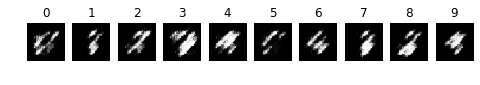

Epoch :  2 Iteration :  100 G_loss :  5.028794 D_loss :  0.023158092
Epoch :  2 Iteration :  200 G_loss :  9.717317 D_loss :  0.0045183594
Epoch :  2 Iteration :  300 G_loss :  6.442294 D_loss :  0.024102107
Epoch :  2 Iteration :  400 G_loss :  6.170888 D_loss :  0.019835146
Epoch :  2 Iteration :  500 G_loss :  6.096366 D_loss :  0.0345349
Epoch :  2 Iteration :  600 G_loss :  6.4561243 D_loss :  0.01243839


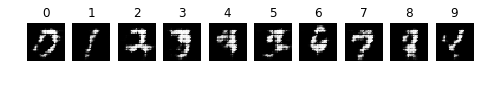

Epoch :  3 Iteration :  100 G_loss :  7.1208324 D_loss :  0.06902422
Epoch :  3 Iteration :  200 G_loss :  5.032328 D_loss :  0.037977967
Epoch :  3 Iteration :  300 G_loss :  6.6090856 D_loss :  0.05891398
Epoch :  3 Iteration :  400 G_loss :  6.4705524 D_loss :  0.12141471
Epoch :  3 Iteration :  500 G_loss :  5.4829774 D_loss :  0.030126907
Epoch :  3 Iteration :  600 G_loss :  5.4994836 D_loss :  0.047265124


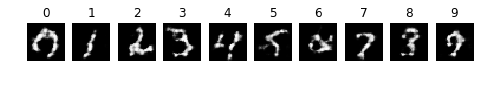

Epoch :  4 Iteration :  100 G_loss :  7.3189144 D_loss :  0.025995426
Epoch :  4 Iteration :  200 G_loss :  8.196081 D_loss :  0.023682212
Epoch :  4 Iteration :  300 G_loss :  5.503038 D_loss :  0.07068355
Epoch :  4 Iteration :  400 G_loss :  6.1325264 D_loss :  0.047419727
Epoch :  4 Iteration :  500 G_loss :  5.249253 D_loss :  0.17986852
Epoch :  4 Iteration :  600 G_loss :  4.5058355 D_loss :  0.11264761


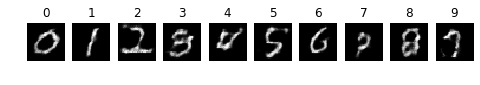

Epoch :  5 Iteration :  100 G_loss :  4.308399 D_loss :  0.053168826
Epoch :  5 Iteration :  200 G_loss :  3.556846 D_loss :  0.13074528
Epoch :  5 Iteration :  300 G_loss :  3.006919 D_loss :  0.45980072
Epoch :  5 Iteration :  400 G_loss :  4.031654 D_loss :  0.16772296
Epoch :  5 Iteration :  500 G_loss :  1.1613233 D_loss :  0.34636828
Epoch :  5 Iteration :  600 G_loss :  4.995488 D_loss :  0.10371809


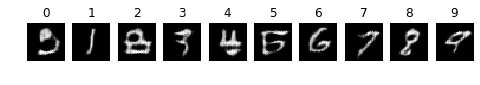

Epoch :  6 Iteration :  100 G_loss :  4.7797103 D_loss :  0.3228134
Epoch :  6 Iteration :  200 G_loss :  8.574947 D_loss :  0.30505243
Epoch :  6 Iteration :  300 G_loss :  3.6612034 D_loss :  0.50118786
Epoch :  6 Iteration :  400 G_loss :  4.357397 D_loss :  0.19265704
Epoch :  6 Iteration :  500 G_loss :  3.79112 D_loss :  0.05875379
Epoch :  6 Iteration :  600 G_loss :  4.591414 D_loss :  0.389586


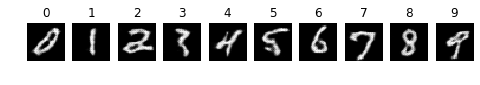

Epoch :  7 Iteration :  100 G_loss :  3.8931124 D_loss :  0.8384071
Epoch :  7 Iteration :  200 G_loss :  3.0467255 D_loss :  0.2962202
Epoch :  7 Iteration :  300 G_loss :  5.216987 D_loss :  0.21809357
Epoch :  7 Iteration :  400 G_loss :  5.7789226 D_loss :  0.20534065
Epoch :  7 Iteration :  500 G_loss :  3.149642 D_loss :  0.4584692
Epoch :  7 Iteration :  600 G_loss :  3.8289335 D_loss :  1.187705


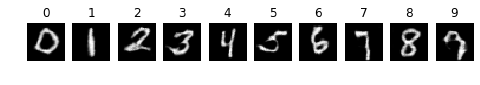

Epoch :  8 Iteration :  100 G_loss :  3.7658072 D_loss :  0.17477606
Epoch :  8 Iteration :  200 G_loss :  2.73701 D_loss :  0.19754618
Epoch :  8 Iteration :  300 G_loss :  4.234871 D_loss :  0.24611174
Epoch :  8 Iteration :  400 G_loss :  5.760847 D_loss :  0.16483669
Epoch :  8 Iteration :  500 G_loss :  3.7447326 D_loss :  0.255839
Epoch :  8 Iteration :  600 G_loss :  3.882962 D_loss :  0.2546943


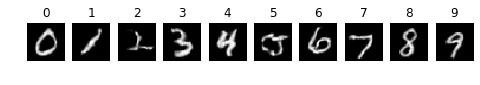

Epoch :  9 Iteration :  100 G_loss :  2.7528956 D_loss :  0.08820014
Epoch :  9 Iteration :  200 G_loss :  3.6695592 D_loss :  0.35076895
Epoch :  9 Iteration :  300 G_loss :  2.0421762 D_loss :  0.69785935
Epoch :  9 Iteration :  400 G_loss :  4.720707 D_loss :  0.21413177
Epoch :  9 Iteration :  500 G_loss :  2.7059543 D_loss :  0.6027193
Epoch :  9 Iteration :  600 G_loss :  1.3253442 D_loss :  0.4128


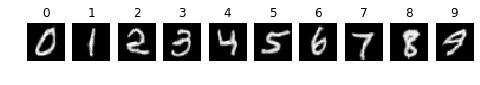

Epoch :  10 Iteration :  100 G_loss :  3.6179798 D_loss :  0.5634484
Epoch :  10 Iteration :  200 G_loss :  2.650017 D_loss :  0.21932189
Epoch :  10 Iteration :  300 G_loss :  3.6402667 D_loss :  0.27088457
Epoch :  10 Iteration :  400 G_loss :  1.2817377 D_loss :  0.4527463
Epoch :  10 Iteration :  500 G_loss :  2.9588418 D_loss :  0.65852946
Epoch :  10 Iteration :  600 G_loss :  2.1285133 D_loss :  0.37903985


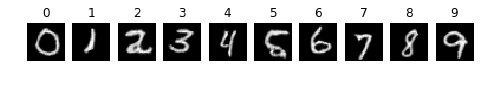

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
print("Iteration maker Done !")
history = {}
history['g_loss']=[]
history['d_loss']=[]
# Training loop
for epoch in range(10):
    avg_loss = 0
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_img, batch_c) in enumerate(data_iter):
        
        # Preparing train data
        X = batch_img.to(device)
        
        C = d_fill[batch_c].to(device)
        
        real_lab = torch.ones(batch_size, 1).to(device)
        
        fake_lab = torch.zeros(batch_size, 1).to(device)
        
        
        # Training Discriminator
        D_pred = D.forward(X, C)
        d_loss_real = criterion(D_pred.view(-1, 1), real_lab)
        real_score = D_pred
        
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        c = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
        
        fake_images = G.forward(z, g_fill[c].to(device))
        G_pred = D.forward(fake_images, d_fill[c].to(device))
        d_loss_fake = criterion(G_pred.view(-1, 1), fake_lab)
        fake_score = G_pred
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        # Training Generator
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        c = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
        
        fake_images = G.forward(z, g_fill[c].to(device))
        G_pred = D.forward(fake_images, d_fill[c].to(device))
        
        g_loss = criterion(G_pred.view(-1, 1), real_lab)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        history['g_loss'].append(g_loss.data.cpu().numpy())
        history['d_loss'].append(d_loss.data.cpu().numpy())
        
        if (i+1)%100 == 0 :
            print("Epoch : ", epoch+1, "Iteration : ", i+1, "G_loss : ", g_loss.data.cpu().numpy(), "D_loss : ", d_loss.data.cpu().numpy())
    plot_generator()
    
torch.save(G.state_dict(), './trained/Conditional_GAN/sd_gen')
torch.save(D.state_dict(), './trained/Conditional_GAN/sd_dis')

torch.save(G, './trained/Conditional_GAN/gen.pt')
torch.save(D, './trained/Conditional_GAN/dis.pt')

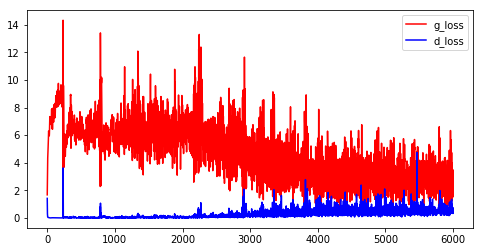

In [8]:
plt.figure(figsize=(8,4))
plt.plot(history['g_loss'], 'r-')
plt.plot(history['d_loss'], 'b-')
plt.legend(['g_loss', 'd_loss'], loc=1)
plt.show()